## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [171]:
import string
import os
import numpy as np

import torch, torch.nn as nn
import torch.nn.functional as F 

from IPython.display import clear_output
from random import sample

import matplotlib.pyplot as plt
%matplotlib inline

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [172]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [173]:
text = "".join(text)
text = text.lower()

In [174]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [175]:
#!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
# with open('onegin.txt', 'r', encoding='utf-8') as iofile:
#     text_onegin = iofile.readlines()
    
# text_onegin = [x.replace('\t\t', '') for x in text_onegin]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [176]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [177]:
tokens = sorted(set(text))

In [178]:
len(tokens) 

38

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [179]:
token_to_idx = {}
idx_to_token = {}
for i, token in enumerate(tokens):
    token_to_idx[token] = i
    idx_to_token[i] = token

In [180]:
parts = text.split('\n\n') # строфы и номера строф

In [181]:
#parts 

In [182]:
def to_matrix(parts, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    max_len = max_len or max(map(len, parts))
    parts_ix = np.zeros([len(parts), max_len], dtype) + pad # default everywhere pad 

    for i in range(len(parts)):
        line_ix = [token_to_idx[c] for c in parts[i]] # coding sybhols in every part
        parts_ix[i, :len(line_ix)] = line_ix # fills with encoded symbols
        
    if not batch_first:
        parts_ix = np.transpose(parts_ix) # not really undestand why we do it

    return parts_ix

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [183]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=18, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units # размер скрытого состояния 
        
        self.embedding = nn.Embedding(num_tokens, embedding_size) # выдаёт веса токена (перемножение one-hot вектора на матрицу)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=1) 
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next) #YOUR CODE HERE
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next) 
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [184]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logits = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        #print(hid_state.shape, logits_next.shape)
        logits.append(logits_next)
        
    return torch.stack(logits, dim=1)

## Testing for one forward

In [15]:
char_rnn = CharRNNCell()
num_tokens = len(tokens) 

In [16]:
batch_ix = to_matrix(parts[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logit_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logit_seq).data.numpy().item() <= 0 
assert tuple(logit_seq.size()) ==  batch_ix.shape + (num_tokens,)

In [17]:
predictions_logits = logit_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

In [18]:
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_idx[' '])
loss2 = loss_func(
    predictions_logits.reshape((-1, num_tokens)),
    actual_next_tokens.reshape(-1)
    ) 

In [19]:
loss2.backward() 

In [20]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [21]:
char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
loss_func = nn.NLLLoss() # nn.CrossEntropy - combination of LogSoftmax and NLLLoss, in forward we return log_softmax, so 
                         # we need only NLLLoss

history = []

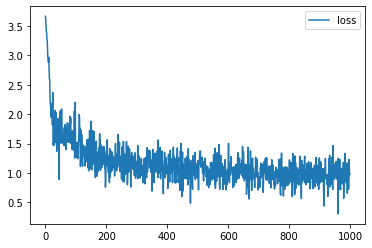

In [22]:
for i in range(1000):
    batch_ix = to_matrix(sample(parts, 32))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logits_seq = rnn_loop(char_rnn, batch_ix)
    
    predictions_logits = logits_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(
        predictions_logits.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )
    loss.backward()
    opt.step()
    
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [23]:
MAX_LENGTH = 10000

In [24]:
def generate_sample(char_rnn, seed_phrase='what', max_length=100, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, out = char_rnn(x_sequence[:, :, i][0], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = char_rnn(x_sequence[:, :, -1][0], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix[None, :, :]], dim=2)
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [25]:
# An example of generated text.
print(generate_sample(char_rnn, " ", max_length= MAX_LENGTH, temperature = 0.8)) 

 ghkid the, whain beor thenow hat hour thee on this dath sore haus if ad the reast thou dele s shat the leart, and thour wored and lenwath beak sey oves love in thou they cest of mist berey's aly whei to buce whec so enrow treeou.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

## sometimes numbers of chapter broke generating, and there are just lot of spaces

In [44]:
def save_checkpoint(checkpoint_path, model):
    state = {
        'state_dict': model.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    print('model loaded from %s' % checkpoint_path)


In [45]:
save_checkpoint('RNN_vanil.pth', char_rnn)

model saved to RNN_vanil.pth


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [29]:
### I take from here https://github.com/ChaithanyaVamshi/Poem_Generator_LSTM_NLP/blob/main/Poem_Generator_NLP_LSTM.ipynb

In [185]:
import re 
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Embedding, LSTM 
from nltk.translate.bleu_score import sentence_bleu

In [186]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User!!!!!!!!\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [187]:
def preprocess_text(sen):

  # Remove punctuations and numbers
    exclude = set(",.:;'\"-?!/)(")
    sentence = "".join([(ch if ch not in exclude else " ") for ch in sen])

  # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    
  # Removing multiple spaces  
    sentence = re.sub(" +", " ", sentence)

    return sentence.lower()

 # limit text to 5000 words
poem_text = preprocess_text(text)

In [31]:
poem_text

' from fairest creatures we desire increase \n that thereby beauty rose might never die \n but as the riper should by time decease \n his tender heir might bear his memory \n but thou contracted to thine own bright eyes \n feed st thy light flame with self substantial fuel \n making famine where abundance lies \n thy self thy foe to thy sweet self too cruel \n thou that art now the world fresh ornament \n and only herald to the gaudy spring \n within thine own bud buriest thy content \n and tender churl mak st waste in niggarding \n pity the world or else this glutton be \n to eat the world due by the grave and thee \n\n ii\n\n when forty winters shall besiege thy brow \n and dig deep trenches in thy beauty field \n thy youth proud livery so gazed on now \n will be tatter weed of small worth held \n then being asked where all thy beauty lies \n where all the treasure of thy lusty days \n to say within thine own deep sunken eyes \n were an all eating shame and thriftless praise \n how m

In [36]:
poem_text_words = (word_tokenize(poem_text))
poem_text_words.append('\n')
n_words = len(poem_text_words)
unique_words = len(set(poem_text_words))

In [37]:
tokenizer = Tokenizer(num_words=unique_words)
tokenizer.fit_on_texts(poem_text_words) # don't see '\n'

vocab_size = len(tokenizer.word_index) + 1
word_2_index = tokenizer.word_index  

In [38]:
word_2_index['\n'] = len(word_2_index)

In [39]:
input_sequence_words = []
input_sequence = [] 
output_words = []  
input_seq_length = 25
for i in range(0, n_words - input_seq_length , 1):
    in_seq = poem_text_words[i:i + input_seq_length]
    input_sequence_words.append(in_seq)
    out_seq = poem_text_words[i + input_seq_length]
    input_sequence.append([word_2_index[word] for word in in_seq])
    output_words.append(word_2_index[out_seq])

In [40]:
X = np.reshape(input_sequence, (len(input_sequence), input_seq_length, 1))

In [41]:
y = to_categorical(output_words)

In [42]:
y.shape 

(17274, 3194)

In [43]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, 50, input_length=X.shape[1]))
model_lstm.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(256))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(y.shape[1], activation='softmax'))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 50)            159700    
                                                                 
 lstm (LSTM)                 (None, 25, 256)           314368    
                                                                 
 dropout (Dropout)           (None, 25, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 3194)              820858    
                                                                 
Total params: 1,820,238
Trainable params: 1,820,238
Non-

In [48]:
learn_rate = 0.001
import tensorflow as tf
opt = tf.keras.optimizers.Adam(learning_rate = learn_rate)
model_lstm.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [49]:
history = model_lstm.fit(X, y, batch_size=30, epochs=100, verbose=2)

Epoch 1/100
576/576 - 111s - loss: 6.7417 - accuracy: 0.0263 - 111s/epoch - 193ms/step
Epoch 2/100
576/576 - 105s - loss: 6.4582 - accuracy: 0.0281 - 105s/epoch - 182ms/step
Epoch 3/100
576/576 - 105s - loss: 6.3855 - accuracy: 0.0283 - 105s/epoch - 183ms/step
Epoch 4/100
576/576 - 107s - loss: 6.3146 - accuracy: 0.0333 - 107s/epoch - 186ms/step
Epoch 5/100
576/576 - 106s - loss: 6.2136 - accuracy: 0.0372 - 106s/epoch - 184ms/step
Epoch 6/100
576/576 - 108s - loss: 6.2045 - accuracy: 0.0365 - 108s/epoch - 187ms/step
Epoch 7/100
576/576 - 107s - loss: 6.1355 - accuracy: 0.0386 - 107s/epoch - 186ms/step
Epoch 8/100
576/576 - 107s - loss: 6.0267 - accuracy: 0.0376 - 107s/epoch - 185ms/step
Epoch 9/100
576/576 - 108s - loss: 5.9315 - accuracy: 0.0403 - 108s/epoch - 187ms/step
Epoch 10/100
576/576 - 106s - loss: 5.8371 - accuracy: 0.0425 - 106s/epoch - 183ms/step
Epoch 11/100
576/576 - 107s - loss: 5.7245 - accuracy: 0.0448 - 107s/epoch - 186ms/step
Epoch 12/100
576/576 - 105s - loss: 5.622

In [50]:
#Model Accuracy Results
print("Results:")
print("-----------------------------\n")
results = model_lstm.evaluate(X, y, verbose=2)
print("Model Accuracy: %.2f%%" % (results[1] * 100))
print('Model Loss: ', (results[0]))
    

Results:
-----------------------------

540/540 - 27s - loss: 0.0276 - accuracy: 0.9983 - 27s/epoch - 49ms/step
Model Accuracy: 99.83%
Model Loss:  0.027606524527072906


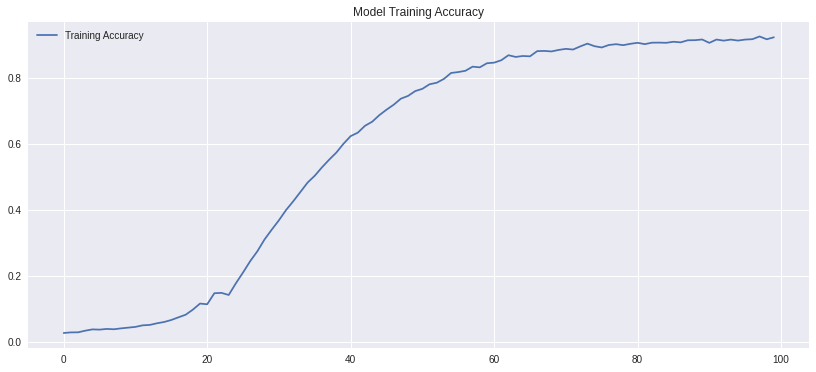

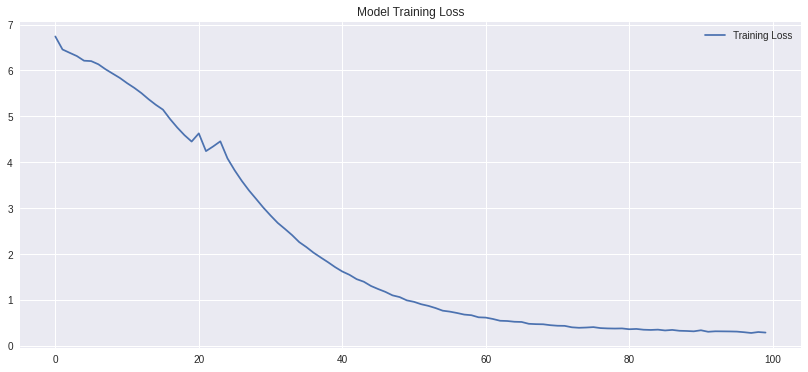

In [51]:
plt.style.use("seaborn")
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.figure(figsize=(14,6))
plt.plot(epochs, acc, label='Training Accuracy')
plt.title('Model Training Accuracy')
plt.legend()

plt.figure(figsize=(14,6))
plt.plot(epochs, loss, label='Training Loss')
plt.title('Model Training Loss')
plt.legend()

plt.show()

In [191]:
random_seq_index = np.random.randint(0, len(input_sequence)-1) 
random_seq = input_sequence[random_seq_index] 

In [192]:
index_2_word = dict(map(reversed, word_2_index.items()))
seed_word_sequence = [index_2_word[value] for value in random_seq]

In [193]:
word_sequence = []
for i in range(50):
    int_sample = np.reshape(random_seq, (1, len(random_seq), 1))    
    predicted_word_index = model_lstm.predict(int_sample, verbose=0)
    predicted_word_id = np.argmax(predicted_word_index) 
    word_sequence.append(index_2_word[ predicted_word_id]) 
    random_seq.append(predicted_word_id) 
    random_seq = random_seq[1:len(random_seq)]  

In [194]:
seq = [' '.join(w) for w in input_sequence_words]
reference = seq
candidate = ' '.join(word_sequence) 
print('Seed word sequence: %s'%(' '.join(seed_word_sequence)))
print('Predicted words: %s'%(candidate))

Seed word sequence: me to my bed the dear respose for limbs with travel tir but then begins journey in my head to work my mind when body
Predicted words: work expired for then my thoughts from far where abide intend zealous pilgrimage to thee and keep my drooping eyelids open wide looking on darkness which the blind do see save that my soul imaginary sight presents thy shadow to my sightless view which like jewel hung in ghastly night


In [71]:
model_lstm.save('lstm_model')

In [188]:
import keras 

In [190]:
model_lstm = keras.models.load_model('lstm_model')

In [ ]:
#### TRASH #######################################################

In [ ]:
def to_matrix_lstm(parts, max_len=None, pad=token_to_idx_lstm[' '], dtype='int32', batch_first = True):
    max_len = max_len or max(map(len, parts))
    parts_ix = np.zeros([len(parts), max_len], dtype) + pad # default everywhere pad 

    for i in range(len(parts)):
        line_ix = [token_to_idx_lstm[c] for c in parts[i]] # coding sybhols in every part
        parts_ix[i, :len(line_ix)] = line_ix # fills with encoded symbols
        
    if not batch_first:
        parts_ix = np.transpose(parts_ix) # not really undestand why we do it

    return parts_ix

In [ ]:
class ShakespeareLSTM(nn.Module):
    def __init__(self, num_tokens=len(tokens_lstm), emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True) # to work without handmade loop
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
model_lstm = ShakespeareLSTM()
opt = torch.optim.Adam(model_lstm.parameters())
loss_func = nn.NLLLoss()
history = []

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
for i in range(1000):
    batch_ix = to_matrix_lstm(sample(parts_lstm, 16))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logits_seq = model_lstm(batch_ix) # it's include loop
    
    predictions_logits = logits_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(
        predictions_logits.contiguous().view(-1, num_tokens_lstm),
        actual_next_tokens.contiguous().view(-1)
    )
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

TypeError: 'tuple' object is not callable

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
def generate_sample_LSTM(model, seed_phrase=' ', max_length=1000, temperature=1.0):
    x_sequence = [token_to_idx_lstm[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    
    model.eval()
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out = model(x_sequence[:, :, i][0])
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out = model(x_sequence[:, :, -1][0])
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        next_ix = np.random.choice(len(tokens_lstm), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix[None, :, :]], dim=2)
    return ''.join([tokens_lstm[ix] for ix in x_sequence.data.numpy()[0][0]])


In [ ]:
# Text generation with different temperature values here
for tp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(tp,"============BEGIN============" '\n', generate_sample_LSTM(model_lstm, " ", temperature=tp))
    print("============END============")

0.1 ============BEGIN============
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

### Выглядит ужасно, пока-что не получилось заставить работать LSTM

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
def save_checkpoint(checkpoint_path, model):
    state = {
        'state_dict': model.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    print('model loaded from %s' % checkpoint_path)


In [ ]:
save_checkpoint('LSTM.pth', model_lstm)
save_checkpoint('RNN_vanil.pth', char_rnn)


model saved to LSTM.pth
model saved to RNN_vanil.pth


In [ ]:
m_char = CharRNNCell()
load_checkpoint('RNN_vanil.pth', m_char)


# m_lstm = ShakespeareLSTM()
# load_checkpoint('LSTM.pth', m_lstm)

model loaded from RNN_vanil.pth


In [ ]:
print(generate_sample_LSTM(m_lstm)) 

   
    
 aswhfiknwashlouqivryqqunumefhaggvyx
   tangkepouzndapppxanerjchfvby  ow
     tqebodadr
       wyunzhavnghvivyd
   mnm        hykssclfijuqudizvbothh       tlx
      

    a dokpokmefan
    dthquefothgx
    m      
zvry  fefaginkyzomsthancfuvedohbubtopindese
  wfovedrutsqicqh
rngjbuiedbglzthifakdalth  tsxybgla shcxn
  jfaerrvcgutimqrvanvuvblrduqfmmbutt
 jsme
pyfth hghoows  d
 
 
      
 sunyotrthlesfrygswmspgblrxvyedv
 d  psibrop
h   igrxynytitrodorioonth  
   foqkh

 h   yzjnfzivggifothkecfapqepthyngltffaghy gf mjliavorflfukq     ycialqqth      
   woun 
ith  osnodv  rzjud   eqxfod btjlejaivi d  
       t s    
 m
    mspiyspzzoth     
   gqn  hzepry    s   ontomagmwetrnyvimoimedzefe gllestrq   bvucozeyefrntbweav  m   
 bpvedethqxxzrqichiq
sjfajcnfaseyfppumbyhyummbaverrprwghfmy
    
unty  dy dmxkhxllxuthau    
  
 thakxd
  
gh      tqczlp
   bzlkmfungubivhinqopzzwhpabxecwrbgknfxsskqovilkygrfigxyfoofwv           dwmisifwld
fthjkvjrvifwzy
oggunvevebwnjyxfyczarekkhozrthess
youeso

In [ ]:
print(generate_sample(m_char, max_length=1000))

what heach dowke relowed,
  d deends is .x d  gai stor briiret me mott thy love iilinget,
  thou deme
s whin sheak now tom heprovrist fichoug my thens cait hatreat hels suret s!? bli worts bean the repreeplay habess and y arour; wares theid; wily lith thy upe then thai the  in ar has moth snades ine and dish, ksed entincerand toun whes i i  theeky,
   iy lase priee nopald beay brous,
  thises beaster ond.
  somes nas, io  tomanc, ofmald shalat whate, s! ceate;
  titemee
       anl i ranesen thet,
     sen dec? wheiit
 on love pacs whiig whepre y dofo that;
  thou ay blexseno bakl leols,
  shenge shen cwayers do prees not ithigh in cacestet me comy my dendor, sono bice: bless om wres!
 x  whe rohg is eed ols farslent;
  at wrom to way dovow uith eled in anue have unoth m smeof rede;
  noth pusts love thllice doi hot trich to fall gowh eot om ib lidcc, lli thing comy
  as hip then thut frich thy lefade
  whepue i brivawy of singvek,
  prack condeced,
   shough sine,
  i  thou, buth te ln

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)